# make_GTIs.ipynb

Reads in a text file list of NICER event lists, gets the generic GTIs in the FITS file generated by the auto pipeline, only keeps the GTIs that are longer than your segment length (like 32 seconds, so that you don't have a bunch of 1-second GTIs hanging around for no good reason), saves those GTIs to a new FITS file, and writes the file names of the new GTIs to a text file for reading in to quicklook_segments.py.

In [6]:
from astropy.table import Table
from astropy.io import fits
from astropy.time import Time
import numpy as np
import os
import subprocess
import matplotlib.pyplot as plt
from xcor_tools_nicer import find_nearest, clock_to_mjd
%matplotlib inline

### Need to have the list of event lists already made

In [10]:
homedir = os.path.expanduser('~')
exe_dir = os.getcwd()
obj_name = "Swift_J1728.9-3613"
obj_prefix = "SwiftJ1728"
min_length = 16  ## seconds

# exe_dir = "%s/Documents/Research/NICER_exploration" % (homedir)
exe_dir = "%s/Documents/Research/%s" % (homedir, obj_prefix)
data_dir = "%s/Reduced_data/%s/" % (homedir, obj_name)
evt_list = "%s/in/%s_evtlists.txt" % (exe_dir, obj_prefix)
data_files = [line.strip() for line in open(evt_list)]

In [11]:
print(os.path.isfile(data_dir+data_files[0]))
print(os.path.isfile(data_dir+data_files[-1]))

True
True


# For a list of many data files:

In [12]:
gti_list = []
for data_file in data_files:
    if os.path.isfile(data_dir+data_file):
        obsID = data_file.split("/")[-1].split("_")[0][2:]
        evtID = data_file.split("/")[-1].split(".")[0]
        print(evtID)
#         ex
        gti_file = "%s/%s_%dsGTIs.fits" % (data_dir, evtID, min_length)
        if not os.path.isfile(gti_file):
            hdu_list = fits.open(data_dir+data_file, memmap=True)
#             print(hdu_list.info())
#             try:
            gti_tab = Table(hdu_list[2].data)
            gti_length = gti_tab['STOP'] - gti_tab['START']
            print("\tGTI len: ", len(gti_length))
            print("\tMin GTI: ", np.min(gti_length))
            print("\tMax GTI: ", np.max(gti_length))
            to_delete = np.where(gti_length < min_length)[0]
            del gti_tab[to_delete]
            print("\tFinal GTI len: ", len(gti_tab))
#             print(gti_tab['START'])
            if len(gti_tab) > 0:
                gti_tab.write(gti_file, overwrite=True, format='fits')
            else:
                print("\t", obsID, evtID)
#             except:
#                 print("Could not read GTI extension: %s" % (data_dir+data_file))
        if os.path.isfile(gti_file):
            gti_list.append(os.path.basename(gti_file))
        else:
            print("\t GTI file was not created.")
    else:
        print("File does not exist: %s" % (data_dir+data_file))
print("Done!")

ni1200550101_0mpu7_cl
	GTI len:  66
	Min GTI:  1.0
	Max GTI:  173.0
	Final GTI len:  25
ni1200550102_0mpu7_cl
	GTI len:  347
	Min GTI:  1.0
	Max GTI:  319.0
	Final GTI len:  172
ni1200550103_0mpu7_cl
	GTI len:  326
	Min GTI:  1.0
	Max GTI:  453.0
	Final GTI len:  167
ni1200550104_0mpu7_cl
	GTI len:  20
	Min GTI:  1.0
	Max GTI:  1121.0
	Final GTI len:  17
ni1200550105_0mpu7_cl
	GTI len:  282
	Min GTI:  4.3779611587524414e-05
	Max GTI:  1108.0
	Final GTI len:  18
ni1200550106_0mpu7_cl
	GTI len:  875
	Min GTI:  4.1604042053222656e-05
	Max GTI:  1071.0
	Final GTI len:  28
ni1200550107_0mpu7_cl
	GTI len:  299
	Min GTI:  3.191828727722168e-05
	Max GTI:  1039.0
	Final GTI len:  21
ni1200550108_0mpu7_cl
	GTI len:  16
	Min GTI:  1.0
	Max GTI:  1024.0
	Final GTI len:  15
ni1200550109_0mpu7_cl
	GTI len:  60
	Min GTI:  1.0
	Max GTI:  797.0
	Final GTI len:  18
ni1200550110_0mpu7_cl
	GTI len:  90
	Min GTI:  1.0
	Max GTI:  509.0
	Final GTI len:  9
ni1200550111_0mpu7_cl
	GTI len:  45
	Min GTI:  0.0089

### Write the file name to the GTI list, for reading into quicklook_segments.py

In [13]:
gti_out_file = "%s/in/%s_%dsGTIlists.txt" % (exe_dir, obj_prefix, min_length)
with open(gti_out_file, 'w') as f:
    [f.write("%s\n" % gti_file) for gti_file in gti_list]

# Here be dragons and untested and/or outdated code

### For just one data file:

In [6]:
hdu_list = fits.open(data_file, memmap=True)
print(hdu_list.info())
gti_tab = Table(hdu_list[2].data)

FileNotFoundError: [Errno 2] No such file or directory: 'gx3394-3.evt'

In [22]:
gti_length = gti_tab['STOP'] - gti_tab['START']

In [23]:
print(np.min(gti_length))
print(np.max(gti_length))

0.000479280948638916
1108.0


In [24]:
print(len(np.where(gti_length < 1)[0]))
print(len(np.where(gti_length >= 16)[0]))
print(len(np.where(gti_length >= 32)[0]))
print(len(np.where(gti_length >= 64)[0]))
print(len(np.where(gti_length >= 128)[0]))

76
211
192
167
121


/anaconda3/envs/nicer/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


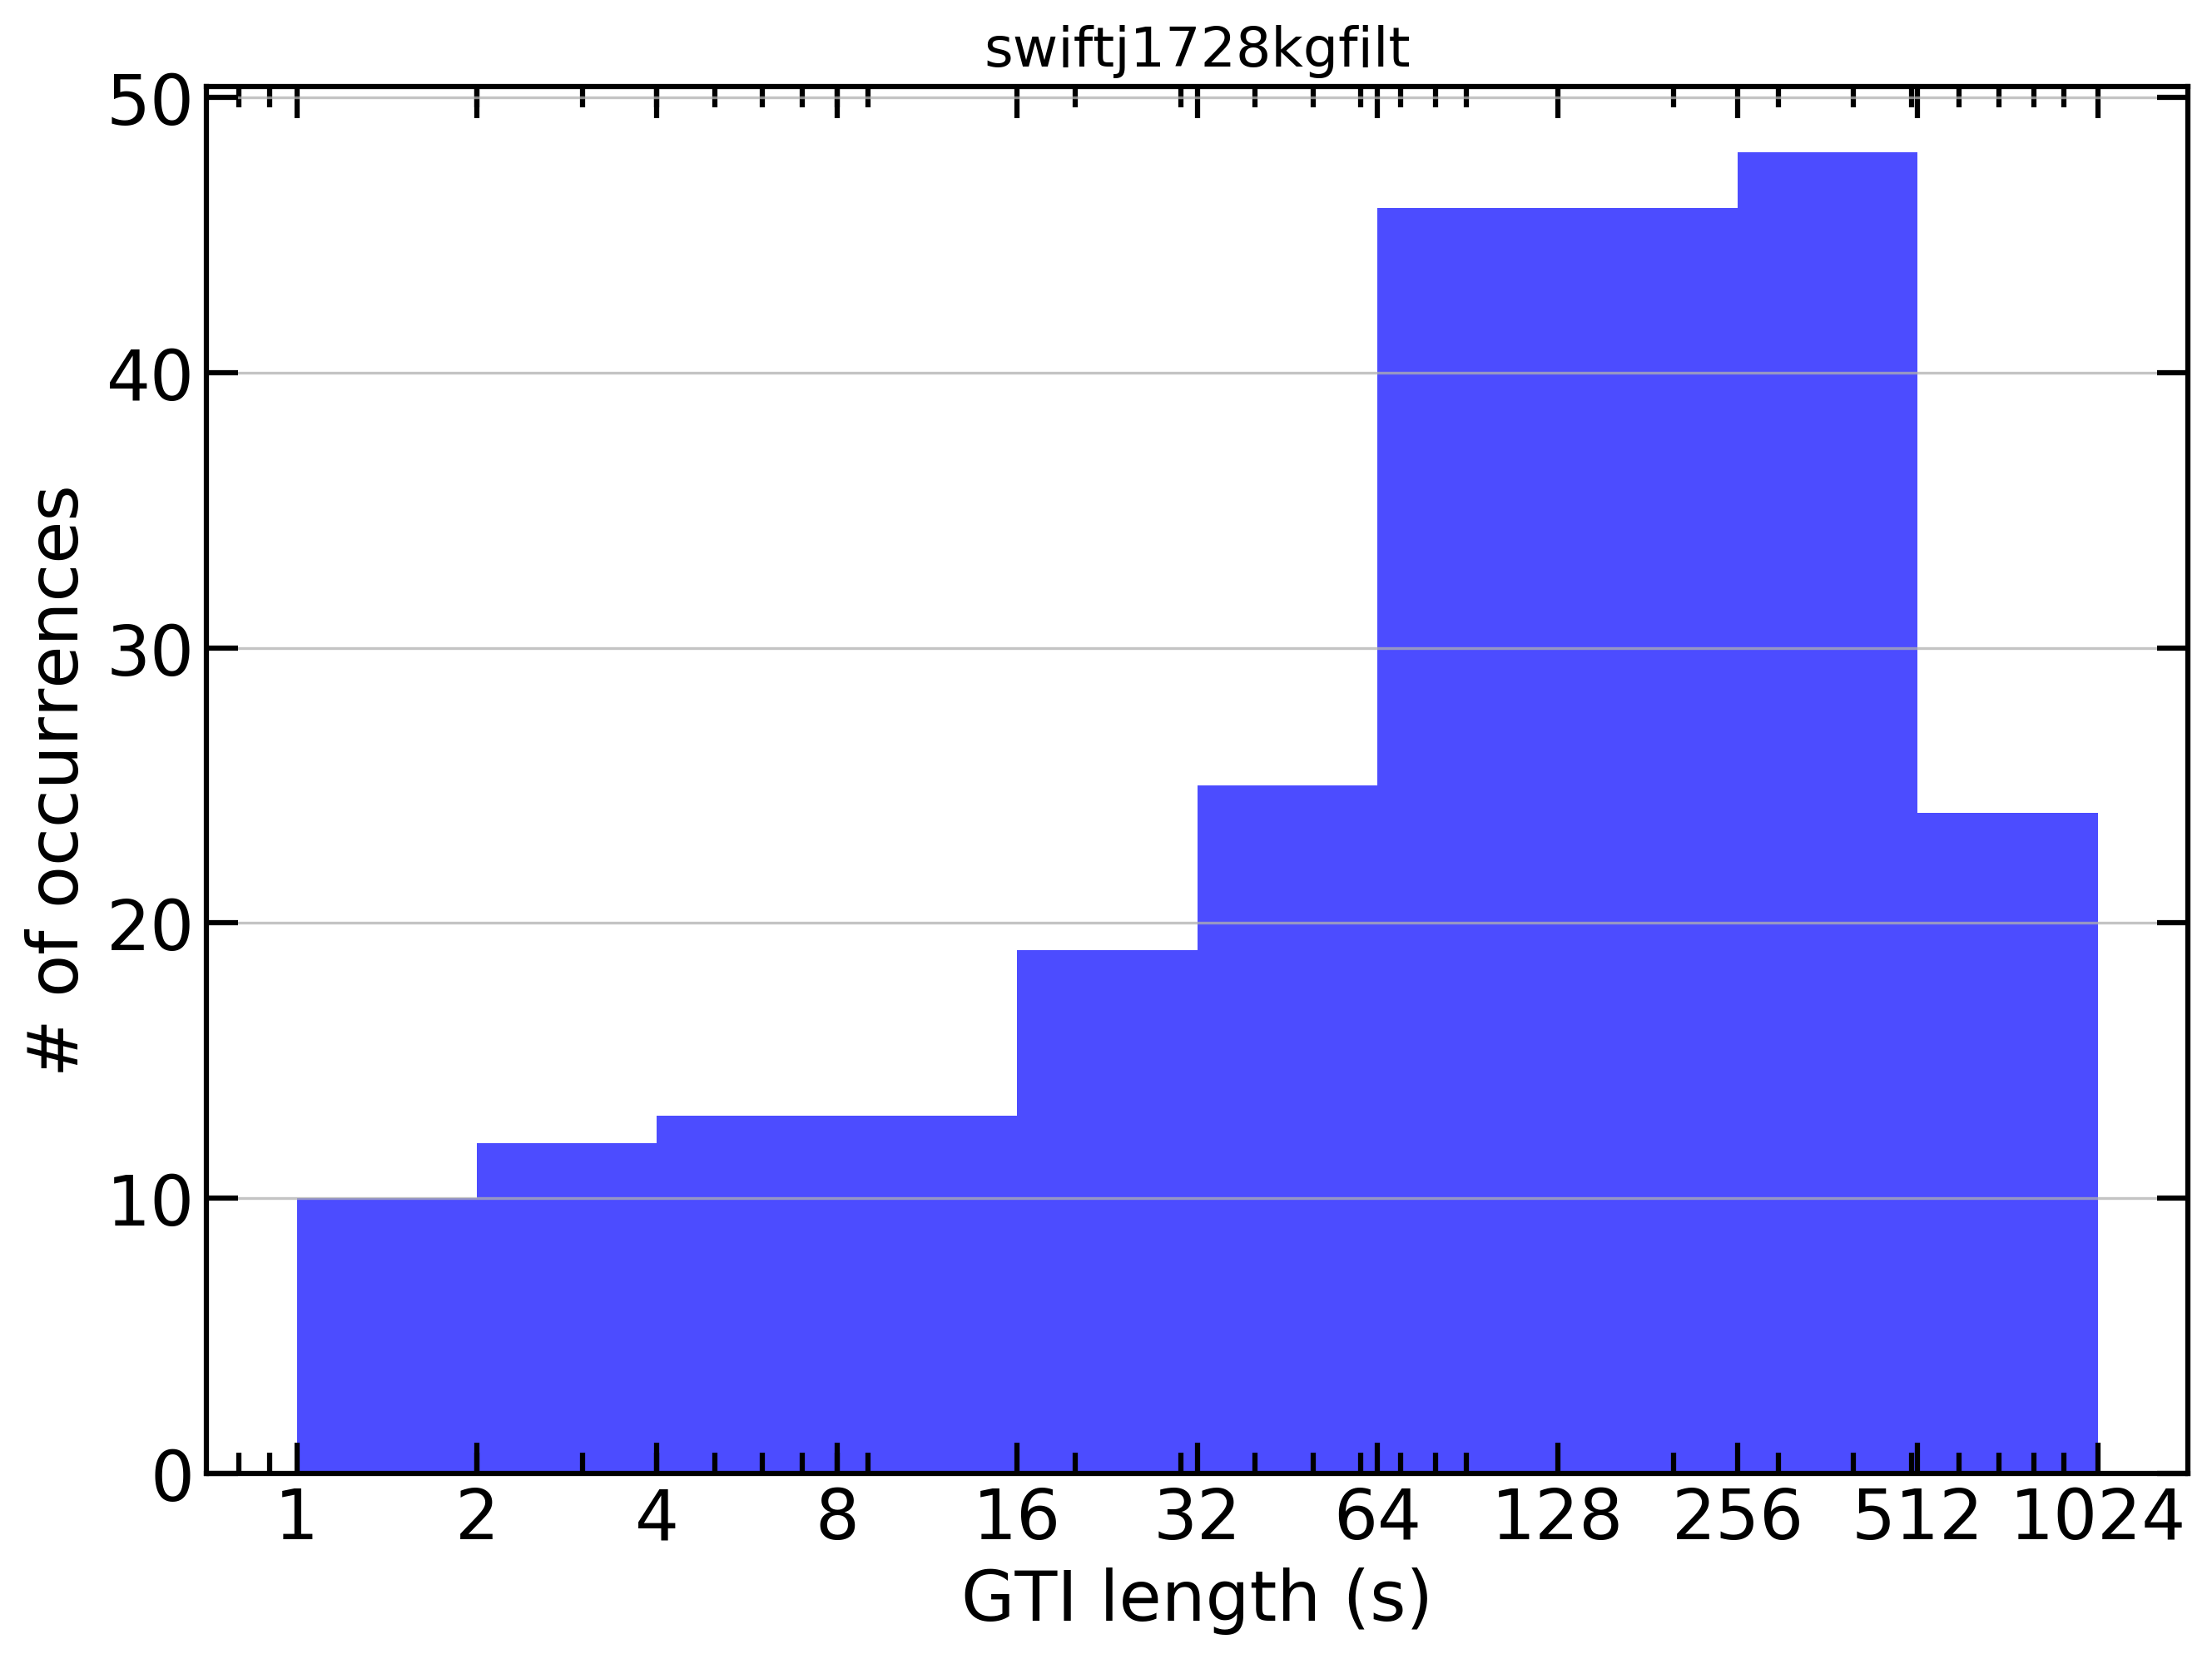

In [25]:
bin_edges = np.asarray([2**x for x in range(0,11)])
fig, ax = plt.subplots(1, 1, figsize=(9,6.75), dpi=300, tight_layout=True)
n, bins, patches = plt.hist(x=gti_length, bins=bin_edges, color='blue', alpha=0.7)
ax.grid(axis='y', alpha=0.75)
ax.set_xscale('log')
ax.set_xlabel('GTI length (s)', fontsize=20)
ax.set_ylabel('# of occurrences', fontsize=20)
x_maj_loc = bin_edges
x_maj_labels = bin_edges
ax.set_xticks(x_maj_loc)
ax.tick_params(axis='x', labelsize=20, bottom=True, top=True,
                labelbottom=True, labeltop=False, direction="in")
ax.tick_params(axis='y', labelsize=20, left=True, right=True,
                labelleft=True, labelright=False, direction="in")
ax.tick_params(which='major', width=1.5, length=9, direction="in")
ax.tick_params(which='minor', width=1.5, length=6, direction="in")
ax.set_xticklabels(x_maj_labels, rotation='horizontal', fontsize=20)
ax.tick_params(which='minor', width=1.5, top=True, right=True, length=6, direction='in')
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.5)
ax.set_title(basename, fontsize=16)
plt.show()

In [26]:
to_delete = np.where(gti_length < 64)[0]
# print(to_delete)

In [27]:
del gti_tab[to_delete]

In [28]:
gti_tab.info

<Table length=224>
 name  dtype 
----- -------
START float64
 STOP float64

In [29]:
gti_tab.write("%s/%s_64sGTIs.fits" % (data_dir, basename), overwrite=True, format='fits')